In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and explore data
print("Loading data...")
df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
print(f"Training data shape: {df.shape}")
print(f"Classes: {df['class'].value_counts()}")

Loading data...
Training data shape: (8000, 30)
Classes: class
forest        6159
farm           841
impervious     669
grass          196
water          105
orchard         30
Name: count, dtype: int64


In [3]:
# Identify NDVI columns
ndvi_columns = [col for col in df.columns if col.endswith('_N') or 'ndvi' in col.lower()]
if not ndvi_columns:
    ndvi_columns = [col for col in df.columns if col not in ['ID', 'class']]

print(f"NDVI columns identified: {len(ndvi_columns)}")
print(f"First few NDVI columns: {ndvi_columns[:5]}")

NDVI columns identified: 27
First few NDVI columns: ['20150720_N', '20150602_N', '20150517_N', '20150501_N', '20150415_N']


In [4]:
# Clean and convert NDVI data to numeric
def clean_numeric_data(df, cols):
    """Convert columns to numeric, handling various data issues"""
    df_clean = df.copy()
    for col in cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        df_clean[col] = df_clean[col].clip(lower=Q1, upper=Q3)
    return df_clean

df_clean = clean_numeric_data(df, ndvi_columns)
print(f"Missing values after cleaning:\n{df_clean[ndvi_columns].isnull().sum().sum()} total missing values")

Missing values after cleaning:
25040 total missing values


In [5]:
# Advanced missing value imputation
def advanced_imputation(df, ndvi_cols):
    """Advanced imputation strategy for NDVI time series"""
    df_imputed = df.copy()
    for idx, row in df.iterrows():
        ndvi_values = row[ndvi_cols].values.astype(float)
        missing_mask = pd.isna(ndvi_values)
        
        if missing_mask.sum() > 0 and missing_mask.sum() < len(ndvi_values):
            valid_indices = np.where(~missing_mask)[0]
            valid_values = ndvi_values[~missing_mask]
            
            if len(valid_values) >= 2:
                missing_indices = np.where(missing_mask)[0]
                try:
                    interpolated = np.interp(missing_indices, valid_indices, valid_values)
                    ndvi_values[missing_mask] = interpolated
                    df_imputed.loc[idx, ndvi_cols] = ndvi_values
                except Exception as e:
                    series = pd.Series(ndvi_values)
                    series = series.fillna(method='ffill').fillna(method='bfill')
                    df_imputed.loc[idx, ndvi_cols] = series.values
            else:
                if 'class' in df.columns:
                    class_val = df.loc[idx, 'class']
                    class_data = df[df['class'] == class_val]
                    for col in ndvi_cols:
                        if pd.isna(df_imputed.loc[idx, col]):
                            class_mean = class_data[col].mean()
                            if not pd.isna(class_mean):
                                df_imputed.loc[idx, col] = class_mean
    
    for col in ndvi_cols:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mean())
    return df_imputed

df_imputed = advanced_imputation(df_clean, ndvi_columns)

print(f"Missing values after imputation: {df_imputed[ndvi_columns].isnull().sum().sum()}")

Missing values after imputation: 0


In [6]:
def create_time_series_features(df, ndvi_cols):
    """Create comprehensive time series features from NDVI data"""
    feature_list = []
    
    for idx, row in df.iterrows():
        ndvi_series = row[ndvi_cols].values.astype(float)
        
        # Ensure no NaN values
        ndvi_series = np.nan_to_num(ndvi_series, nan=np.nanmean(ndvi_series))
        
        features = {}
        
        features['mean'] = np.mean(ndvi_series)
        features['std'] = np.std(ndvi_series)
        features['min'] = np.min(ndvi_series)
        features['max'] = np.max(ndvi_series)
        features['range'] = np.max(ndvi_series) - np.min(ndvi_series)
        features['median'] = np.median(ndvi_series)
        
        features['q25'] = np.percentile(ndvi_series, 25)
        features['q75'] = np.percentile(ndvi_series, 75)
        features['iqr'] = np.percentile(ndvi_series, 75) - np.percentile(ndvi_series, 25)
        
        x = np.arange(len(ndvi_series))
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, ndvi_series)
            features['trend_slope'] = slope
            features['trend_r2'] = r_value**2
        except:
            features['trend_slope'] = 0
            features['trend_r2'] = 0
        
        if len(ndvi_series) >= 12:
            season_size = len(ndvi_series) // 4
            seasons = [ndvi_series[i*season_size:(i+1)*season_size] for i in range(4)]
            
            for i, season in enumerate(seasons):
                if len(season) > 0:
                    features[f'season_{i}_mean'] = np.mean(season)
                    features[f'season_{i}_std'] = np.std(season)
        
        features['cv'] = np.std(ndvi_series) / np.mean(ndvi_series) if np.mean(ndvi_series) != 0 else 0
        
        if len(ndvi_series) >= 5:
            try:
                window_length = min(5, len(ndvi_series) if len(ndvi_series) % 2 == 1 else len(ndvi_series) - 1)
                if window_length >= 3:
                    smoothed = savgol_filter(ndvi_series, window_length=window_length, polyorder=2)
                    features['smoothed_mean'] = np.mean(smoothed)
                    features['smoothed_std'] = np.std(smoothed)
                    features['noise_level'] = np.mean(np.abs(ndvi_series - smoothed))
                else:
                    features['smoothed_mean'] = np.mean(ndvi_series)
                    features['smoothed_std'] = np.std(ndvi_series)
                    features['noise_level'] = 0
            except:
                features['smoothed_mean'] = np.mean(ndvi_series)
                features['smoothed_std'] = np.std(ndvi_series)
                features['noise_level'] = 0
        
        peaks = []
        for i in range(1, len(ndvi_series)-1):
            if ndvi_series[i] > ndvi_series[i-1] and ndvi_series[i] > ndvi_series[i+1]:
                peaks.append(ndvi_series[i])
        features['peak_count'] = len(peaks)
        features['peak_mean'] = np.mean(peaks) if peaks else np.mean(ndvi_series)
        
        if len(ndvi_series) > 1:
            diff_series = np.diff(ndvi_series)
            features['stability'] = np.mean(np.abs(diff_series))
            features['volatility'] = np.std(diff_series)
        else:
            features['stability'] = 0
            features['volatility'] = 0
            
        if len(ndvi_series) > 1:
            autocorr = np.corrcoef(ndvi_series[:-1], ndvi_series[1:])[0, 1]
            features['autocorr_lag1'] = autocorr if not np.isnan(autocorr) else 0
        else:
            features['autocorr_lag1'] = 0
        
        feature_list.append(features)
    
    feature_df = pd.DataFrame(feature_list)
    feature_df.index = df.index
    
    feature_df = feature_df.fillna(0)
    
    return feature_df

engineered_features = create_time_series_features(df_imputed, ndvi_columns)

print(f"Engineered features shape: {engineered_features.shape}")
print(f"Engineered feature columns: {list(engineered_features.columns)}")

Engineered features shape: (8000, 28)
Engineered feature columns: ['mean', 'std', 'min', 'max', 'range', 'median', 'q25', 'q75', 'iqr', 'trend_slope', 'trend_r2', 'season_0_mean', 'season_0_std', 'season_1_mean', 'season_1_std', 'season_2_mean', 'season_2_std', 'season_3_mean', 'season_3_std', 'cv', 'smoothed_mean', 'smoothed_std', 'noise_level', 'peak_count', 'peak_mean', 'stability', 'volatility', 'autocorr_lag1']


Final feature matrix shape: (8000, 55)
Classes: ['farm' 'forest' 'grass' 'impervious' 'orchard' 'water']
Performing hyperparameter tuning...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/aravindmanoharan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/aravindmanoharan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/aravindmanoharan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/aravindmanoharan/.local/lib/python3.10/site-packages/sk

Best parameters: {'C': 1, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
Best CV score: 0.6424
F1-Score (Macro): 0.6201
F1-Score (Weighted): 0.8942

Classification Report:
              precision    recall  f1-score   support

        farm     0.7012    0.6845    0.6928       168
      forest     0.9624    0.9359    0.9490      1232
       grass     0.5116    0.5641    0.5366        39
  impervious     0.8085    0.8507    0.8291       134
     orchard     0.0714    0.3333    0.1176         6
       water     0.5385    0.6667    0.5957        21

    accuracy                         0.8875      1600
   macro avg     0.5989    0.6725    0.6201      1600
weighted avg     0.9022    0.8875    0.8942      1600



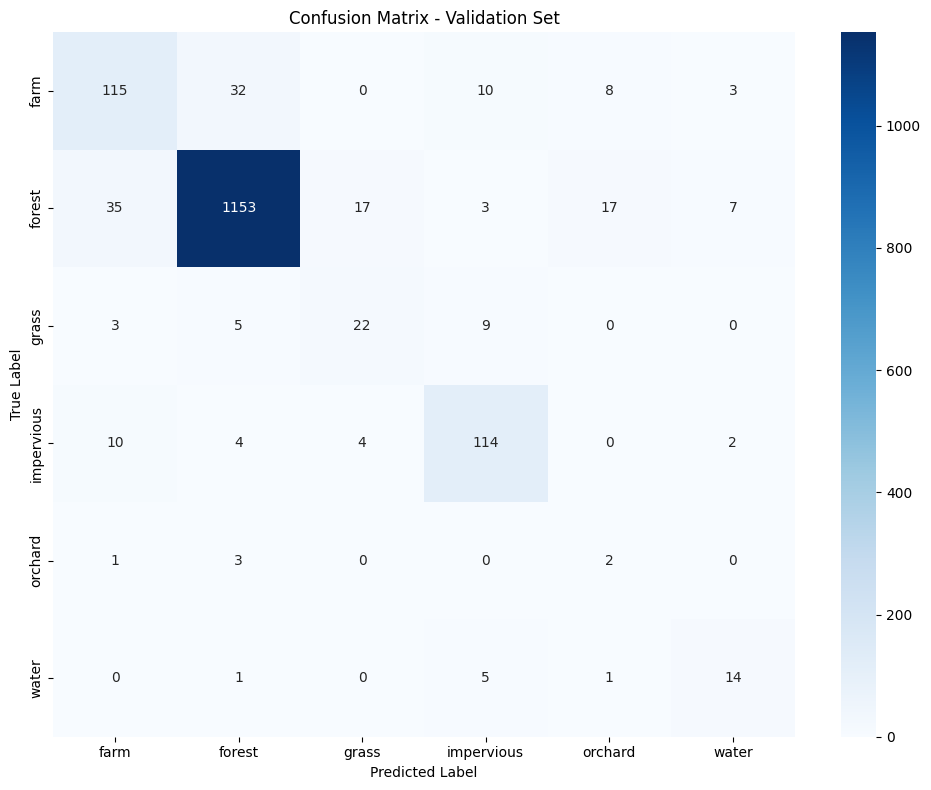

CV F1-Score (Macro): 0.6424 (+/- 0.0377)
Test data shape: (2845, 29)
Test predictions distribution:
forest        1437
farm           543
impervious     358
grass          260
water          151
orchard         96
Name: count, dtype: int64


In [7]:
X_combined = pd.concat([df_imputed[ndvi_columns], engineered_features], axis=1)

X_combined = X_combined.fillna(X_combined.mean())

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_imputed['class'])

print(f"Final feature matrix shape: {X_combined.shape}")
print(f"Classes: {label_encoder.classes_}")

X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

preprocessor = RobustScaler()
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)

print("Performing hyperparameter tuning...")
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 2000],
    'solver': ['lbfgs', 'liblinear'],
    'multi_class': ['ovr', 'multinomial']
}

lr = LogisticRegression(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(
    lr, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val_scaled)

# F1 scores
f1_macro = f1_score(y_val, y_val_pred, average='macro')
f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_val, y_val_pred,
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1_macro')
print(f"CV F1-Score (Macro): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

test_data = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")
test_ids = test_data['ID']
test_features = test_data.drop(['ID'], axis=1)

print(f"Test data shape: {test_data.shape}")

test_clean = clean_numeric_data(test_features, ndvi_columns)

test_imputed = test_clean.copy()
for col in ndvi_columns:
    test_imputed[col] = test_imputed[col].fillna(test_imputed[col].mean())

test_engineered = create_time_series_features(test_imputed, ndvi_columns)

X_test_combined = pd.concat([test_imputed[ndvi_columns], test_engineered], axis=1)

missing_cols = set(X_combined.columns) - set(X_test_combined.columns)
for col in missing_cols:
    X_test_combined[col] = 0

X_test_combined = X_test_combined.reindex(columns=X_combined.columns, fill_value=0)

X_test_combined = X_test_combined.fillna(0)

X_test_scaled = preprocessor.transform(X_test_combined)

test_predictions = best_model.predict(X_test_scaled)
test_predictions_decoded = label_encoder.inverse_transform(test_predictions)

submission = pd.DataFrame({
    'ID': test_ids,
    'class': test_predictions_decoded
})

print(f"Test predictions distribution:")
print(pd.Series(test_predictions_decoded).value_counts())

submission.to_csv("submission.csv", index=False)